In [130]:
# Import and init h2o lib. Running on java
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 35 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,"14 days, 21 hours and 21 minutes"
H2O_cluster_name:,H2O_from_python_paaske_ccxeic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.114 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [131]:
# Reading csv to h2o dataframe 
col_types_train = {
 'chain_name': 'enum',
 'mall_name': 'enum',
 'revenue': 'numeric',
 #'lv1': 'enum',
 'lv2': 'enum',
 'lv3': 'enum',
 'total_nbr_people': 'int',
 'nbr_people_per_store_in_grunnkrets': 'numeric',
 #'counts_gr_lv2': 'numeric',
 #'counts_municipality_lv2': 'numeric',
 #'busstops_within_50m': 'numeric',
 #'busstops_within_100m': 'numeric',
 #'busstops_within_400m': 'numeric',
 #'busstops_within_800m': 'numeric',
 'busstops_within_1500m': 'numeric',
 #'num_stores_within_100m_and_same_lvl2': 'numeric',
 'num_stores_within_500m_and_same_lvl2': 'numeric',
 #'num_stores_within_1km_and_same_lvl2': 'numeric',
 #'num_stores_within_5km_and_same_lvl2': 'numeric',
 #'num_stores_within_10km_and_same_lvl2': 'numeric',
 'num_stores_within_20km_and_same_lvl2': 'numeric',
 'closest_competitor_lv2': 'numeric',
 'mean_revenue_lv3' : 'numeric',
 'mean_revenue_lv2' : 'numeric',
 'median_revenue_lv3' : 'numeric',
 'median_revenue_lv2' : 'numeric',
 'mean_revenue_chain' : 'numeric',
 'median_revenue_lv4' : 'numeric',
 'mean_revenue_lv4' : 'numeric'
 #'num_stores_within_100m_and_same_lvl3': 'numeric',
 #'num_stores_within_500m_and_same_lvl3': 'numeric',
 #'num_stores_within_1km_and_same_lvl3': 'numeric',
 #'num_stores_within_5km_and_same_lvl3': 'numeric',
 #'num_stores_within_10km_and_same_lvl3': 'numeric',
 #'num_stores_within_20km_and_same_lvl3': 'numeric',
 #'closest_competitor_lv3': 'numeric',
 #'municipality_size_group': 'enum',
 #'mean_revenue_for_municipality_size_group': 'numeric',
 #'median_revenue_for_municipality_size_group': 'numeric',
 #'st_dev_of_revenue_for_municipality_size_group': 'numeric',
 #'municipality_rev_group_lv2': 'numeric',
 #'mean_revenue_for_municipality_rev_group_lv2': 'numeric'
 }

col_types_test = {
 'chain_name': 'enum',
 'mall_name': 'enum',
 #'lv1': 'enum',
 'lv2': 'enum',
 'lv3': 'enum',
 'total_nbr_people': 'int',
 'nbr_people_per_store_in_grunnkrets': 'numeric',
 #'counts_gr_lv2': 'numeric',
 #'counts_municipality_lv2': 'numeric',
 #'busstops_within_50m': 'numeric',
 #'busstops_within_100m': 'numeric',
 #'busstops_within_400m': 'numeric',
 #'busstops_within_800m': 'numeric',
 'busstops_within_1500m': 'numeric',
 #'num_stores_within_100m_and_same_lvl2': 'numeric',
 'num_stores_within_500m_and_same_lvl2': 'numeric',
 #'num_stores_within_1km_and_same_lvl2': 'numeric',
 #'num_stores_within_5km_and_same_lvl2': 'numeric',
 #'num_stores_within_10km_and_same_lvl2': 'numeric',
 'num_stores_within_20km_and_same_lvl2': 'numeric',
 'closest_competitor_lv2': 'numeric',
 'mean_revenue_lv3' : 'numeric',
 'mean_revenue_lv2' : 'numeric',
 'median_revenue_lv3' : 'numeric',
 'median_revenue_lv2' : 'numeric',
 'mean_revenue_chain' : 'numeric',
 'median_revenue_lv4' : 'numeric',
 'mean_revenue_lv4' : 'numeric'
 #'num_stores_within_100m_and_same_lvl3': 'numeric',
 #'num_stores_within_500m_and_same_lvl3': 'numeric',
 #'num_stores_within_1km_and_same_lvl3': 'numeric',
 #'num_stores_within_5km_and_same_lvl3': 'numeric',
 #'num_stores_within_10km_and_same_lvl3': 'numeric',
 #'num_stores_within_20km_and_same_lvl3': 'numeric',
 #'closest_competitor_lv3': 'numeric',
 #'municipality_size_group': 'enum',
 #'mean_revenue_for_municipality_size_group': 'numeric',
 #'median_revenue_for_municipality_size_group': 'numeric',
 #'st_dev_of_revenue_for_municipality_size_group': 'numeric',
 #'municipality_rev_group_lv2': 'numeric',
 #'mean_revenue_for_municipality_rev_group_lv2': 'numeric'
 }

train_data = pd.read_csv('feature_data/training_set_dropped.csv')
test_data = pd.read_csv('feature_data/testing_set_dropped.csv')

# Save store ids, then remove this column
store_ids = test_data['store_id'].to_numpy()
ids = pd.DataFrame(store_ids)
ids.rename(columns={0 :'id'}, inplace=True)

train_data = train_data.drop('store_id', axis=1)
test_data = test_data.drop('store_id', axis=1)

train_data.to_csv('feature_data/training_set_dropped.csv', index=False)
test_data.to_csv('feature_data/testing_set_dropped.csv', index=False)

train_data = h2o.import_file('feature_data/training_set_dropped.csv', col_types = col_types_train)
test_data = h2o.import_file('feature_data/testing_set_dropped.csv', col_types = col_types_test)






Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [132]:
# Removing labels from train set
y = "revenue"
x = train_data.columns
x.remove(y)
test_data

chain_name,mall_name,lv2,lv3,total_nbr_people,nbr_people_per_store_in_grunnkrets,busstops_within_1500m,num_stores_within_500m_and_same_lvl2,num_stores_within_20km_and_same_lvl2,closest_competitor_lv2,num_stores_within_20km_and_same_lvl3,closest_competitor_lv3,lv4,mean_revenue_lv2,mean_revenue_lv3,median_revenue_lv2,median_revenue_lv3,mean_revenue_chain,median_revenue_lv4,mean_revenue_lv4
No chain,No mall,0.741937,1.1.1,6.86797,6.86797,4.70953,2.63906,7.58579,0.0321771,3.91202,0.861841,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.30861,2.04239,2.09634
BURGER KING,Stovner Senter,0.741937,1.1.1,7.79235,4.85531,3.80666,2.30259,7.54697,0.000516631,3.82864,1.29872,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.83011,2.04239,2.09634
VULKAN BURGERBAR,No mall,0.741937,1.1.1,8.50147,6.20071,4.77068,1.79176,7.58477,0.30168,3.89182,0.823647,1.1.1.0,1.5555,2.09634,1.53115,2.04239,3.39722,2.04239,2.09634
BURGER KING,No mall,0.741937,1.1.1,6.93828,5.33272,4.02535,2.07944,7.5984,0.0432923,3.93183,1.00078,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.83011,2.04239,2.09634
No chain,No mall,0.741937,1.1.1,7.36771,4.33573,4.35671,4.04305,7.6004,0.0603135,3.89182,0.0843221,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.30861,2.04239,2.09634
No chain,No mall,0.741937,1.1.1,4.77912,1.04512,4.82831,5.39363,7.5994,0.0562585,3.91202,0.166935,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.30861,2.04239,2.09634
No chain,No mall,0.741937,1.1.1,7.31788,4.84024,4.23411,1.60944,7.6039,0.0413104,3.93183,0.632861,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.30861,2.04239,2.09634
BURGER KING,No mall,0.741937,1.1.1,0,0,3.97029,1.09861,4.82831,0.0157106,1.38629,0.705106,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.83011,2.04239,2.09634
BURGER KING,No mall,0.741937,1.1.1,5.01064,4.32413,4.41884,1.60944,5.87774,0.29986,2.07944,1.46031,1.1.1.0,1.5555,2.09634,1.53115,2.04239,1.83011,2.04239,2.09634
MCDONALDS,Trondheim Torg,0.741937,1.1.1,5.96615,2.92755,4.60517,4.67283,5.87212,0.0543383,2.07944,0.0893517,1.1.1.0,1.5555,2.09634,1.53115,2.04239,3.18803,2.04239,2.09634


In [133]:
# Running fit/training on train set with cross validation n=5
aml = H2OAutoML(max_models = 15, seed = 2, stopping_metric = "RMSE", exclude_algos=["XGBoost", "DeepLearning"])
aml.train(x = x, y = y, training_frame = train_data)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.5040640,0.0086083,0.4987537,0.4969626,0.5109821,0.5156093,0.4980120
mean_residual_deviance,0.4398768,0.0216508,0.4214504,0.4244691,0.4651597,0.4617920,0.426513
mse,0.4398768,0.0216508,0.4214504,0.4244691,0.4651597,0.4617920,0.426513
null_deviance,2509.583,112.30203,2561.602,2440.929,2636.1833,2556.9565,2352.2437
r2,0.5623054,0.0133839,0.5794063,0.5627935,0.5516351,0.5468868,0.5708052
residual_deviance,1098.1993,70.69601,1076.8058,1066.2664,1181.9708,1157.2509,1008.7032
rmse,0.6630727,0.0162557,0.6491921,0.6515129,0.6820262,0.6795528,0.6530796
rmsle,0.2782650,0.0037396,0.2729881,0.2769476,0.2824739,0.2811603,0.2777553


In [134]:
lb = aml.leaderboard

In [135]:
# Showing best perforimg models
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_12_20221111_131744,0.663339,0.440019,0.504127,0.278282,0.440019
StackedEnsemble_BestOfFamily_1_AutoML_12_20221111_131744,0.66355,0.440299,0.504579,0.278405,0.440299
GLM_1_AutoML_12_20221111_131744,0.667636,0.445737,0.50838,0.279652,0.445737
XRT_1_AutoML_12_20221111_131744,0.677168,0.458556,0.514318,0.283656,0.458556
GBM_5_AutoML_12_20221111_131744,0.678116,0.459842,0.517765,0.283059,0.459842
GBM_grid_1_AutoML_12_20221111_131744_model_6,0.678389,0.460212,0.517556,0.282839,0.460212
GBM_3_AutoML_12_20221111_131744,0.678657,0.460575,0.517408,0.282949,0.460575
GBM_grid_1_AutoML_12_20221111_131744_model_4,0.678719,0.46066,0.518288,0.283236,0.46066
GBM_2_AutoML_12_20221111_131744,0.678757,0.460711,0.518608,0.283226,0.460711
GBM_1_AutoML_12_20221111_131744,0.679624,0.461888,0.518919,0.283556,0.461888


In [136]:
preds = aml.predict(test_data)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/home/paaske/.local/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'chain_name' has levels not trained on: ["24 7 TRENINGSSENTER", "ACE SHOPS", "AVANCIA SPORT", "BADEMILJØ", "BADERINGEN", "BAROKK FRISØR", "BERTONI NORWAY", "BIRK SPORT", "BLUE ENERGY", "DESINESS", ...25 not listed..., "SALT OG PEPPER HØNEFOSS", "SKOGSTAD DETALJ", "SKY FITNESS", "TIGER OF SWEDEN", "TIPPY", "VARMEFAG INVEST", "VITA EXCLUSIVE", "YOGIS", "ZAVANNA", "ZAXIZ FRISØR"]
  warnings.warn(w)
/home/paaske/.local/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'mall_name' has levels not trained on: ["Aamodt Senter", "Bardufoss Torgsenter", "Bellevuesenteret", "Borgeåsen Senter", "CC Mart'n", "Combisenteret Fiskå", "Coop Mega Hønefoss", "Coop Mega Øvre Årdal", "Cuben Kjøpesenter", "De Syv Søstre kjøpesenter", ...39 not listed..., "Strøget", "Sundt Motehus", "Svelvik Nærsenter", "Tebo Senter", "Trekanten Senter Kristiansand", "Tårnhuset", "Va

In [137]:
#print variable importance
corr = aml.varimp(use_pandas = True)
corr['sum'] = corr.sum(axis=1)
corr = corr.sort_values(by=['sum'])
corr.head(30)

,GLM_1,GBM_1,GBM_5,GBM_4,GBM_grid_1_model_6,GBM_2,GBM_grid_1_model_4,GBM_3,XRT_1,GBM_grid_1_model_1,GBM_grid_1_model_5,DRF_1,GBM_grid_1_model_7,GBM_grid_1_model_2,GBM_grid_1_model_3,sum
median_revenue_lv2,0.001394,0.000070,0.000238,0.000153,0.000465,0.000045,0.000012,0.000105,0.002577,0.001462,0.000484,0.002894,0.004048,0.001230,0.002686,0.017863
mean_revenue_lv2,0.000036,0.000052,0.000324,0.000124,0.000041,0.000084,0.000008,0.000004,0.003703,0.002413,0.000344,0.002346,0.005264,0.001862,0.001493,0.018100
mean_revenue_lv3,0.000148,0.010835,0.006447,0.000336,0.000576,0.001546,0.000102,0.000414,0.025699,0.012555,0.001998,0.045729,0.005631,0.004603,0.024957,0.141577
lv2,0.040271,0.001897,0.002206,0.003194,0.001775,0.002275,0.000895,0.001007,0.007370,0.030456,0.004196,0.013351,0.020144,0.006079,0.014238,0.149356
num_stores_within_20km_and_same_lvl3,0.000578,0.006916,0.003531,0.010439,0.005724,0.004307,0.006875,0.007455,0.018678,0.019349,0.014295,0.027063,0.014295,0.015084,0.018388,0.172977
total_nbr_people,0.000991,0.005075,0.004911,0.012913,0.007321,0.005000,0.003376,0.006406,0.019958,0.015141,0.013807,0.031111,0.032708,0.016348,0.022438,0.197505
closest_competitor_lv3,0.000067,0.005245,0.004298,0.013078,0.007815,0.003631,0.004386,0.004853,0.021008,0.019750,0.013706,0.031064,0.027646,0.027738,0.022888,0.207174
num_stores_within_20km_and_same_lvl2,0.003259,0.006944,0.006436,0.014943,0.010853,0.008734,0.005656,0.008554,0.020068,0.017169,0.018108,0.027472,0.033085,0.020792,0.026600,0.228674
median_revenue_lv3,0.000802,0.001235,0.007853,0.000913,0.000333,0.000388,0.000226,0.000033,0.015229,0.150270,0.001285,0.005362,0.051627,0.002065,0.004741,0.242361
closest_competitor_lv2,0.001788,0.008676,0.008007,0.013845,0.009528,0.007341,0.005059,0.011390,0.023526,0.019722,0.022763,0.035005,0.030727,0.033287,0.019913,0.250577


In [138]:
#preds = h2o.as_list(preds)
print(preds)

  predict
  1.59516
  1.73289
  3.29336
  1.80556
  1.8126
  2.049
  1.60347
  1.99208
  1.81889
  3.40094
[8577 rows x 1 column]



In [139]:
# Convert result to desired format

import pandas as pd
import numpy as np


pandas_preds = preds.as_data_frame()
pandas_preds.rename(columns={'predict' :'predicted'}, inplace=True)
pandas_preds['predicted'] = np.expm1(pandas_preds['predicted'])

def save_submission(pred):
    predicted = pd.DataFrame(pred, columns = ['predicted'])
    output = pd.concat([ids,predicted],axis=1)
    output.to_csv('h2o.csv', index=False)
    
save_submission(pandas_preds)



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_12_20221111_131744,0.336949,0.113534,0.251952,0.15082,0.113534,6126,0.004749,DRF
XRT_1_AutoML_12_20221111_131744,0.447149,0.199942,0.337879,0.19635,0.199942,4636,0.004221,DRF
GBM_grid_1_AutoML_12_20221111_131744_model_3,0.498858,0.248859,0.369134,0.219049,0.248859,556,0.00237,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_7,0.503896,0.253911,0.379093,0.218771,0.253911,674,0.003804,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_2,0.516906,0.267191,0.387804,0.224301,0.267191,536,0.002486,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_5,0.52046,0.270878,0.381871,0.226256,0.270878,541,0.002212,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_1,0.530341,0.281262,0.392363,0.228798,0.281262,495,0.00235,GBM
GBM_4_AutoML_12_20221111_131744,0.538989,0.290509,0.397867,0.23443,0.290509,569,0.002074,GBM
GBM_3_AutoML_12_20221111_131744,0.568172,0.322819,0.418432,0.245532,0.322819,401,0.002078,GBM
StackedEnsemble_AllModels_1_AutoML_12_20221111_131744,0.571642,0.326775,0.433967,0.244307,0.326775,826,0.025488,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

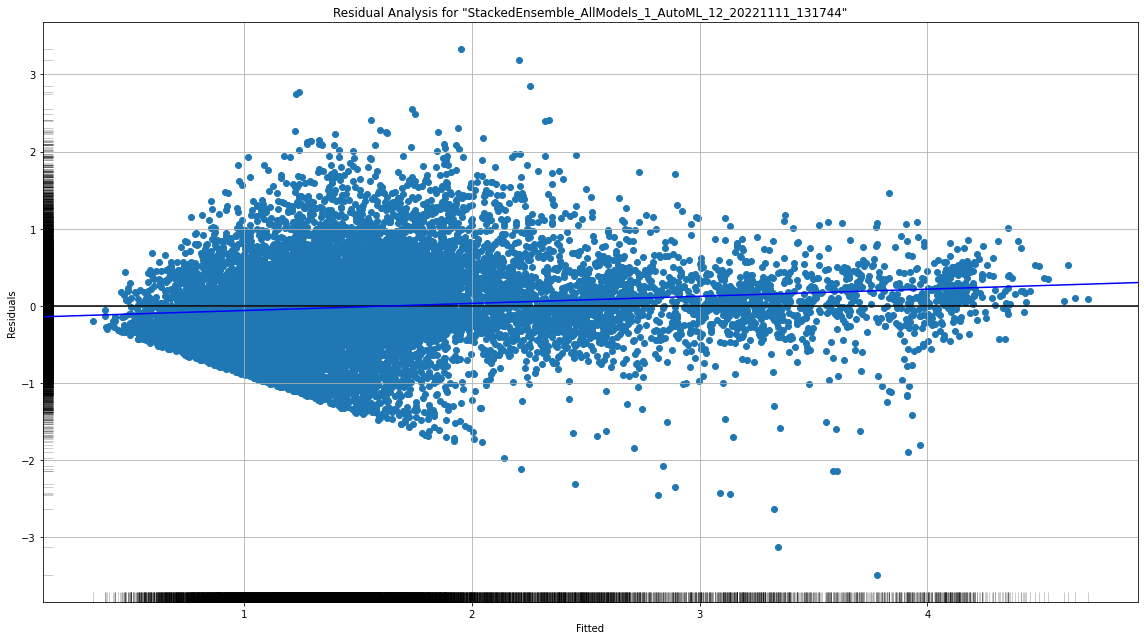

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

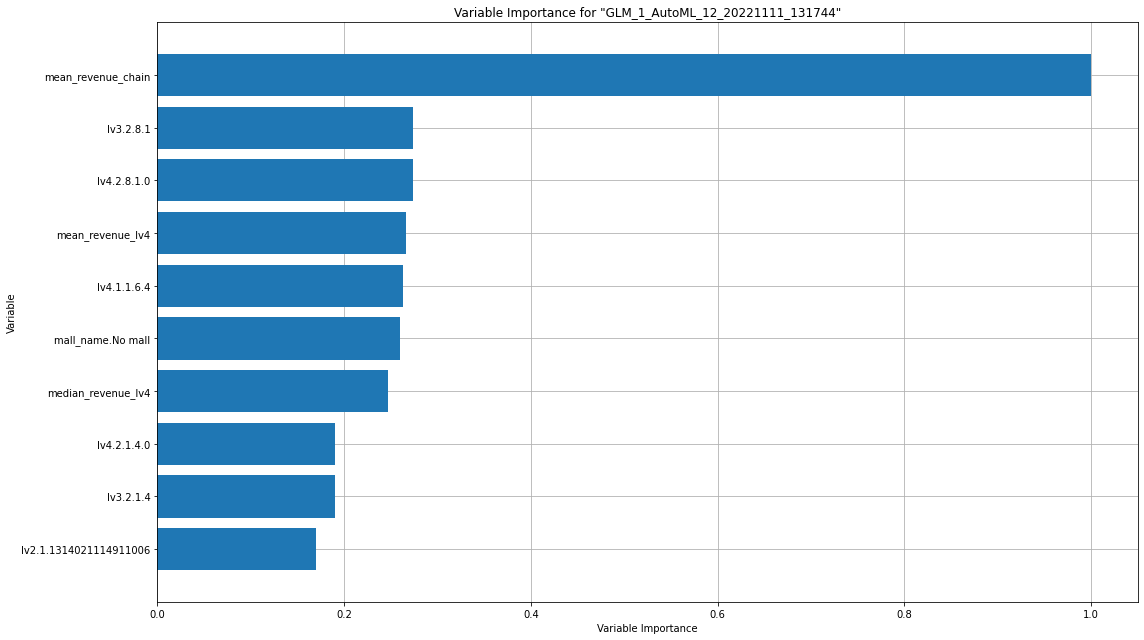

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

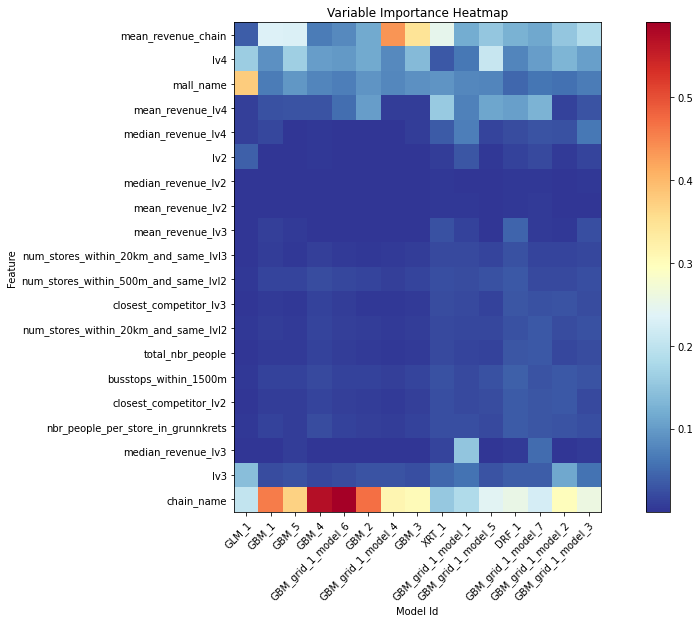

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

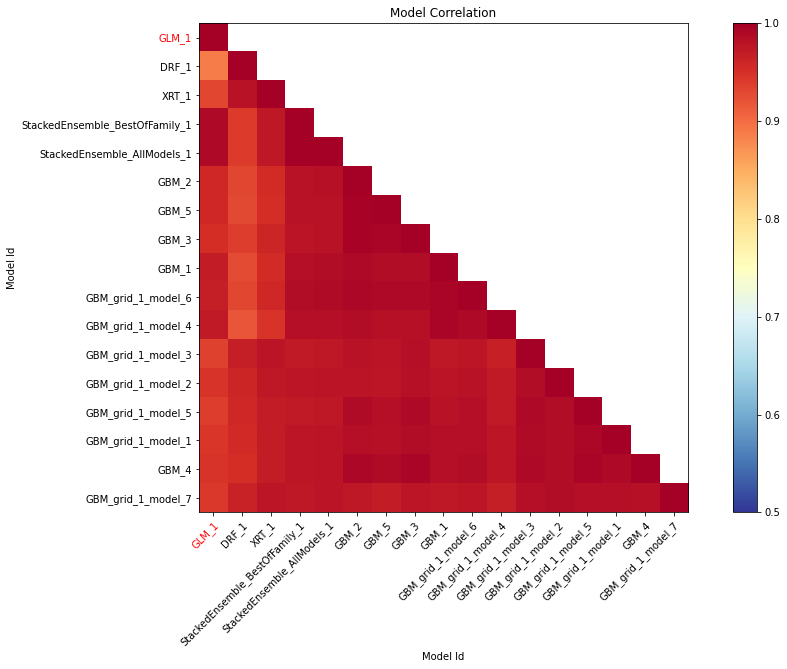

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

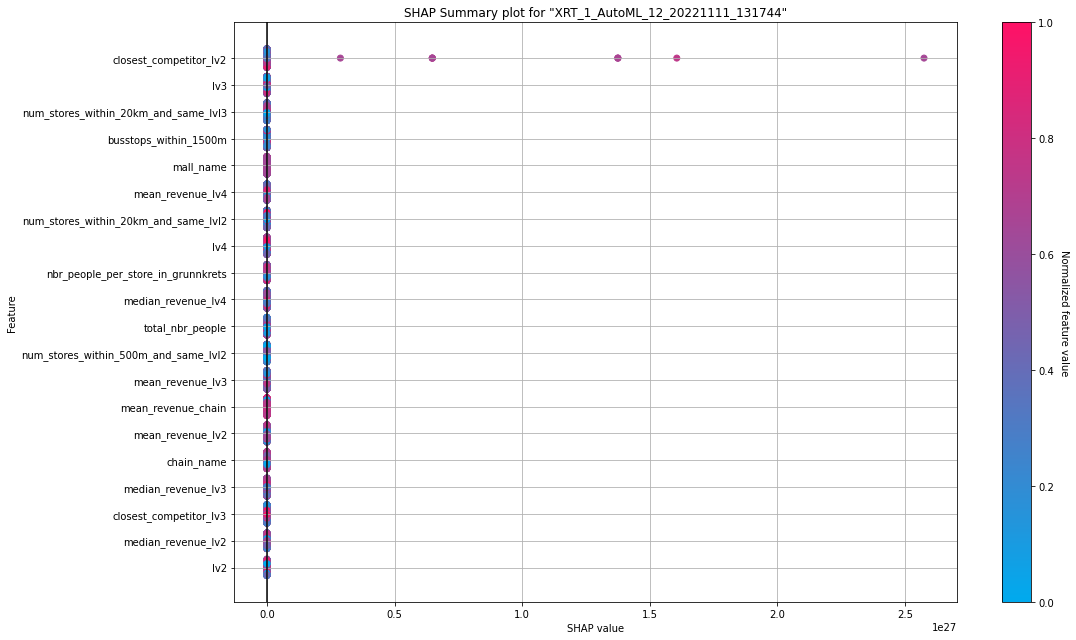

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

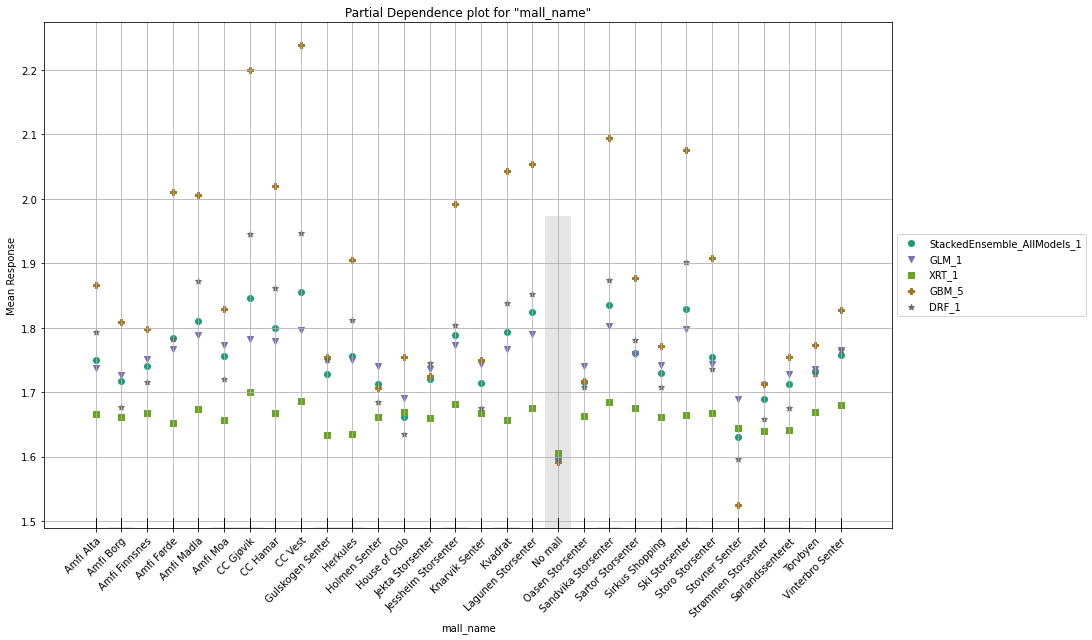

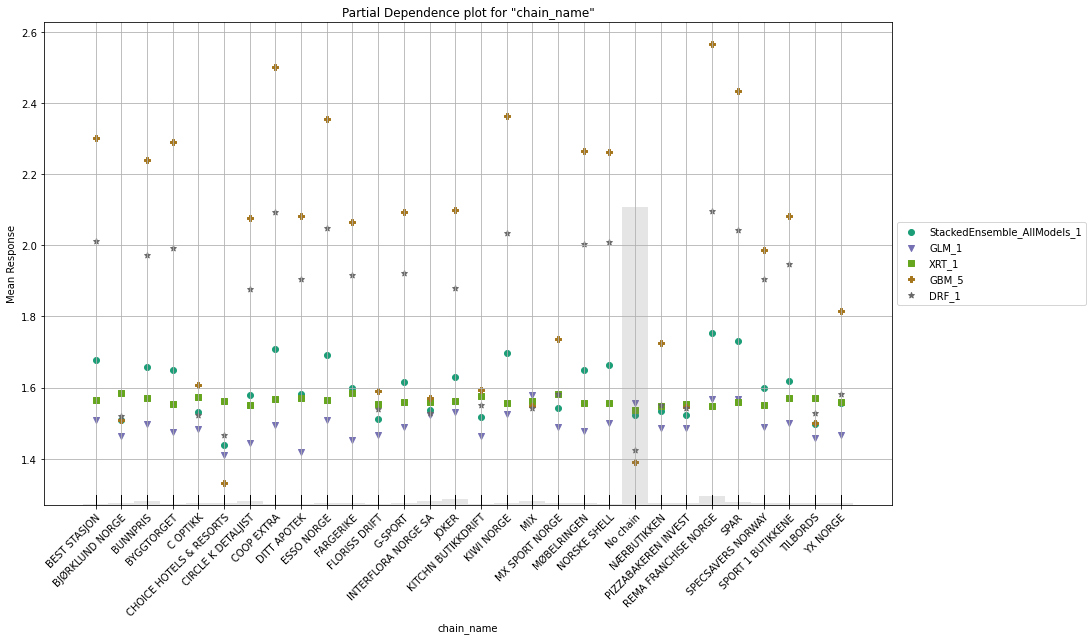

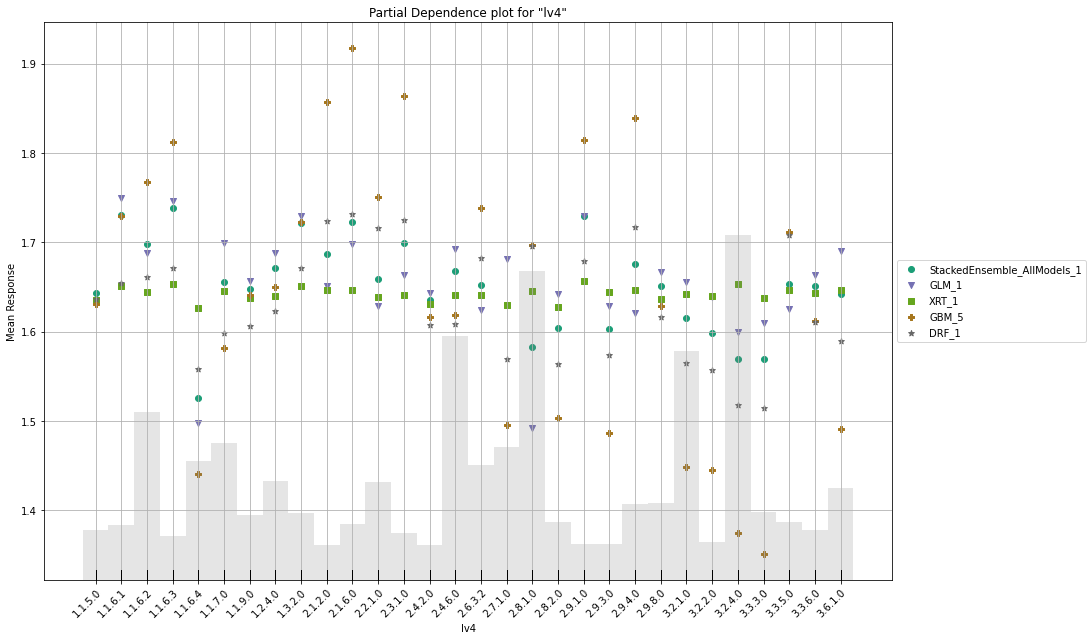

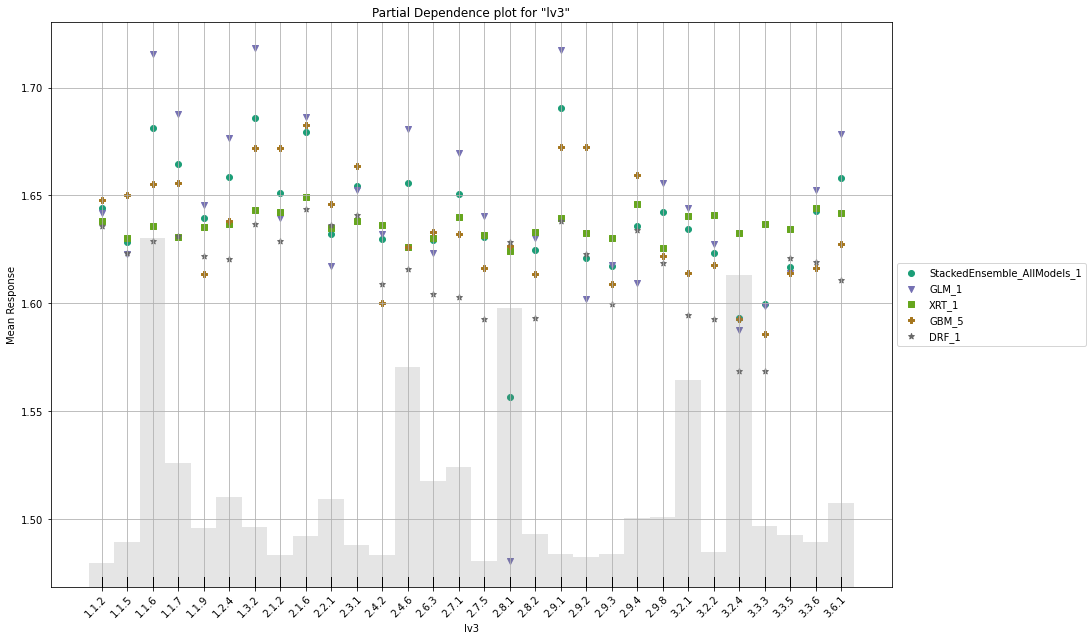

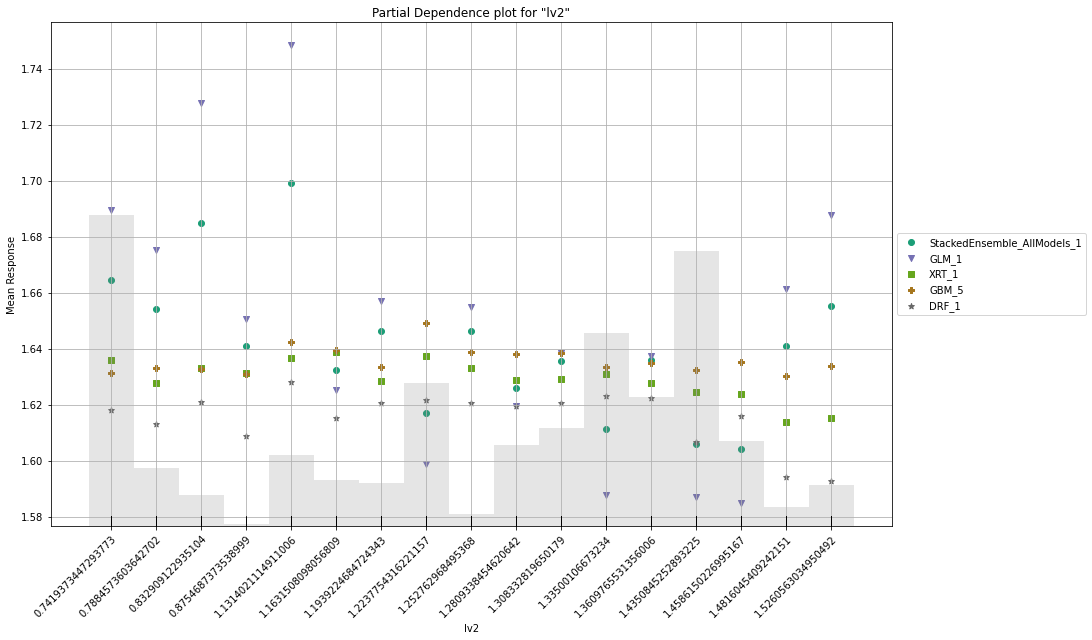

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

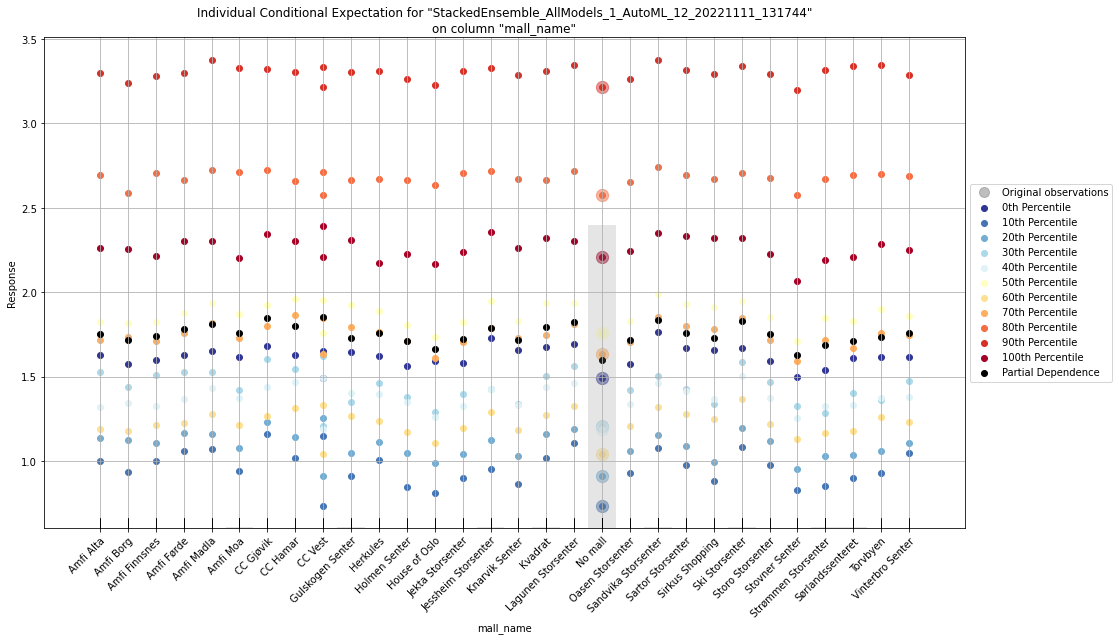

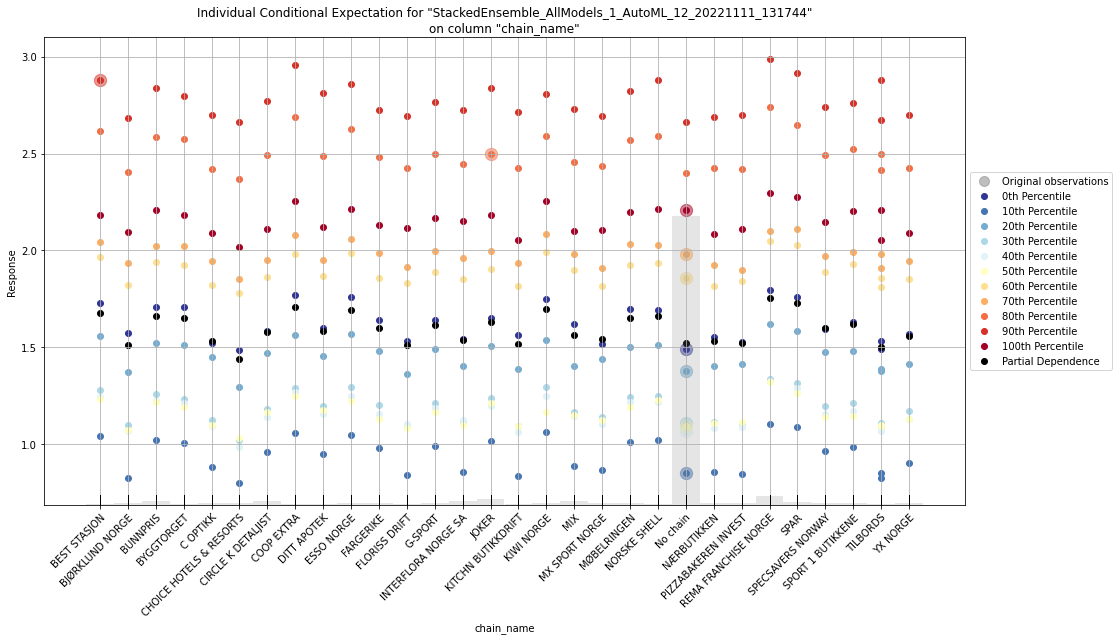

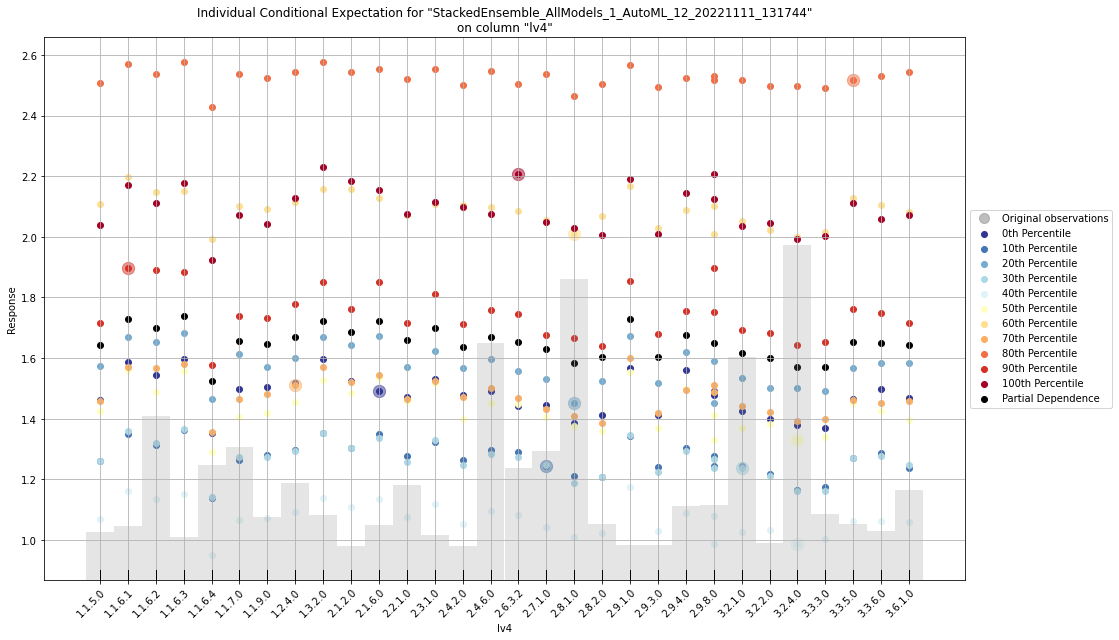

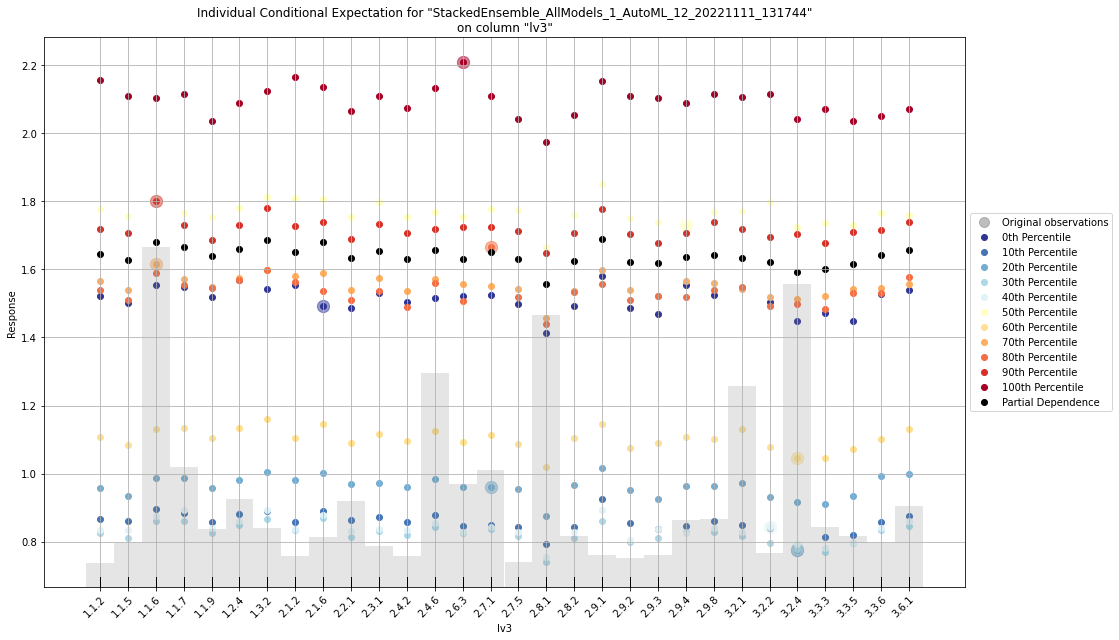

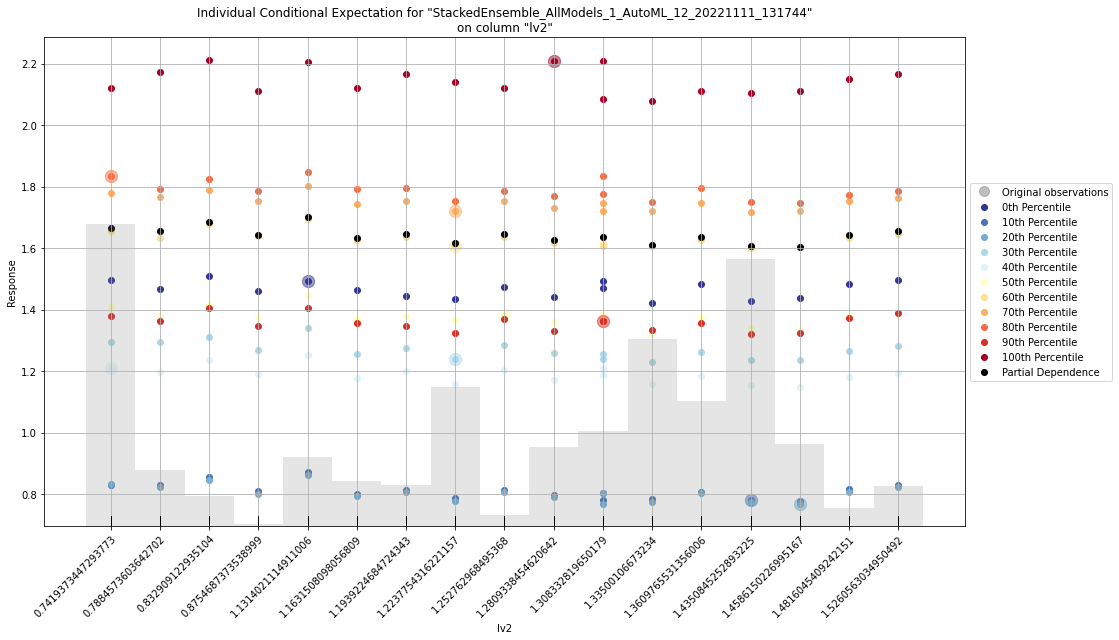

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_12_20221111_131744,0.336949,0.113534,0.251952,0.15082,0.113534,6126,0.004749,DRF
XRT_1_AutoML_12_20221111_131744,0.447149,0.199942,0.337879,0.19635,0.199942,4636,0.004221,DRF
GBM_grid_1_AutoML_12_20221111_131744_model_3,0.498858,0.248859,0.369134,0.219049,0.248859,556,0.00237,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_7,0.503896,0.253911,0.379093,0.218771,0.253911,674,0.003804,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_2,0.516906,0.267191,0.387804,0.224301,0.267191,536,0.002486,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_5,0.52046,0.270878,0.381871,0.226256,0.270878,541,0.002212,GBM
GBM_grid_1_AutoML_12_20221111_131744_model_1,0.530341,0.281262,0.392363,0.228798,0.281262,495,0.00235,GBM
GBM_4_AutoML_12_20221111_131744,0.538989,0.290509,0.397867,0.23443,0.290509,569,0.002074,GBM
GBM_3_AutoML_12_20221111_131744,0.568172,0.322819,0.418432,0.245532,0.322819,401,0.002078,GBM
StackedEnsemble_AllModels_1_AutoML_12_20221111_131744,0.571642,0.326775,0.433967,0.244307,0.326775,826,0.025488,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [140]:
aml.explain(frame = train_data)